In [1]:
#Run this everytime you open the notebook if running in Colab
#If you receive an error or an unknown crash just restart the cell
!git clone https://github.com/matta-research-group/SwiftPol.git
%cd SwiftPol/
!pip install -e .
!pip install rdkit
!pip install openmm
!pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -c conda-forge openff-toolkit rdkit -y
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import random

fatal: destination path 'SwiftPol' already exists and is not an empty directory.
/content/SwiftPol
Obtaining file:///content/SwiftPol
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for swiftpol (pyproject.toml) ... done
  Created wheel for swiftpol: filename=swiftpol-1+unknown-0.editable-py3-none-any.whl size=6058 sha256=8f303e0ef2f974ed1d0943705c9bcffa3433df2c8b02f9f4ac9d219a7ec1e576
  Stored in directory: /tmp/pip-ephem-wheel-cache-74t6vvn2/wheels/4e/f0/c2/fca6b4234fc704ce23ed6ef25aecdd5779f3c7253de944153f
Successfully built swiftpol
✨🍰✨ Everything looks OK!

Looking for: ['openff-toolkit', 'rdkit']

conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache

Pinned packages:
  - python 3.11.*
  - python 3.11.*
  - python_

Enter the probability of adding a chain (between 0 and 1, rest will be probability of crosslinking): 0.1

Enter the probabilities for each of the 4 reactions (they should sum to 1):
Reaction 1 probability: 0.1
Reaction 2 probability: 0.3
Reaction 3 probability: 0.3
Reaction 4 probability: 0.3
Enter the number of reaction iterations: 7


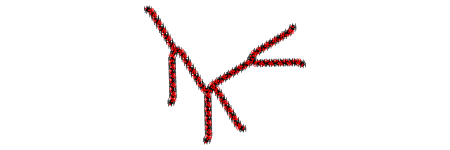

In [7]:
import random
from swiftpol import build
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops

activatorF = Chem.MolFromSmiles('F')
activatorBr = Chem.MolFromSmiles('Br')

#Define the reaction parameters
reaction_templates = [
    ('[Cl:1]-[C:2]-[C:3](-[I:4])-[C:5](=[O:6])-[O:7].[Cl:8]-[C:9]-[C:10](-[I:11])-[C:12](=[O:13])-[O:14].[F:15].[F:16]>>[O:14]-[C:12](=[O:13])-[C:10](-[F:15])-[C:9]-[C:2]-[C:3](-[F:16])-[C:5](=[O:6])-[O:7].[Cl:1].[I:4].[Cl:8].[I:11]', (activatorF, activatorF)),
    ('[O:1]-[C:2](=[O:3])-[C:4](-[F:5])-[C:6]-[C:7]-[C:8](-[F:9])-[C:10](=[O:11])-[O:12].[Cl:13]-[C:14]-[C:15](-[I:16])-[C:17](=[O:18])-[O:19].[Br:20]>>[O:1]-[C:2](=[O:3])-[C:4](-[Br:20])-[C:6]-[C:7]-[C:8](-[C:14]-[C:15](-[I:16])-[C:17](=[O:18])-[O:19])-[C:10](=[O:11])-[O:12].[Cl:1].[F:9].[F:5]', (activatorBr,)),
    ('[O:1]-[C:2](=[O:3])-[C:4](-[Br:5])-[C:6]-[C:7]-[C:8](-[C:9](=[O:10])-[O:11])-[C:12]-[C:13](-[I:14])-[C:15](=[O:16])-[O:17].[Cl:18]-[C:19]-[C:20](-[I:21])-[C:22](=[O:23])-[O:24]>>[O:1]-[C:2](=[O:3])-[C:4](-[C:19]-[C:20](-[I:21])-[C:22](=[O:23])-[O:24])-[C:6]-[C:7]-[C:8](-[C:9](=[O:10])-[O:11])-[C:12]-[C:13](-[I:14])-[C:15](=[O:16])-[O:17].[Br:5].[Cl:18]', ()),
    ('[O:1]-[C:2](=[O:3])-[C:4](-[F:5])-[C:6]-[C:7]-[C:8](-[F:9])-[C:10](=[O:11])-[O:12].[O:13]-[C:14](=[O:15])-[C:16](-[F:17])-[C:18]-[C:19]-[C:20](-[F:21])-[C:22](=[O:23])-[O:24]>>[O:1]-[C:2](=[O:3])-[C:4](-[C:16](-[C:14](=[O:15])-[O:13])(-[C:18]-[C:19]-[C:20](-[F:21])-[C:22](=[O:23])-[O:24]))-[C:6]-[C:7]-[C:8](-[F:9])-[C:10](=[O:11])-[O:12].[F:5]-[F:17]', ()),
]

#Convert SMARTS strings into RDKit reactions
chain_reactions = [(AllChem.ReactionFromSmarts(smarts), reactants) for smarts, reactants in reaction_templates]
crosslink_reactions = [(AllChem.ReactionFromSmarts(smarts), reactants) for smarts, reactants in reaction_templates]  #Same reactions, different reactants

#Define probabilities
#Ask user to input probabilities
chain_addition_prob = float(input("Enter the probability of adding a chain (between 0 and 1, rest will be probability of crosslinking): "))

print("\nEnter the probabilities for each of the 4 reactions (they should sum to 1):")
reaction_probs = []
for i in range(4):
    prob = float(input(f"Reaction {i + 1} probability: "))
    reaction_probs.append(prob)

def build_starting_polymer(sequence=None, monomers=None, polymer_reaction=None, activation_reaction=None):
    """
    Builds a polymer and adds reactive sites.

    Parameters:
        - sequence (str): Polymer sequence
        - monomers (list): List of monomers (SMILES format)
        - polymer_reaction (rdkit reaction): Reaction to form the polymer
        - activation_reaction (rdkit reaction): Reaction to introduce reactive sites

    Returns:
        - starting_polymer (rdkit Mol): PEGDA polymer with reactive sites
    """

    if sequence is None:
      sequence = 'ABBBBBBBBBA'

    if monomers is None:
        monomers = ["IC=CC(=O)OI", "IOCCOI"]  #Default monomers

    if polymer_reaction is None:
        polymer_reaction = AllChem.ReactionFromSmarts(
            "[C:1]-[O:2]-[I:3].[C:4]-[O:5]-[I:6]>>[C:1]-[O:2]-[C:4].[I:3]-[I:6].[O:5]"
        )

    #Build PEGDA polymer
    polymer = build.build_polymer(sequence=sequence, monomer_list=monomers, reaction=polymer_reaction)

    #Default activation reaction (if none provided)
    if activation_reaction is None:
        activation_reaction = AllChem.ReactionFromSmarts('[C:1]=[C:2].[Cl:3].[I:4]>>[C:1](-[I:4])-[C:2]-[Cl:3]')

    activatorCl = Chem.MolFromSmiles('Cl')
    activatorI = Chem.MolFromSmiles('I')

    # Apply activation reaction twice
    starting_polymer = activation_reaction.RunReactants([polymer, activatorCl, activatorI])[0][0]
    Chem.SanitizeMol(starting_polymer)

    starting_polymer = activation_reaction.RunReactants([starting_polymer, activatorCl, activatorI])[0][0]
    Chem.SanitizeMol(starting_polymer)

    Chem.AddHs(starting_polymer)

    return starting_polymer

def modify_polymer(starting_polymer, num_iterations):
    """Applies reactions to the same polymer, adding chains or crosslinking it."""
    polymer_network = starting_polymer  #This is the main polymer we modify
    polymer_history = [polymer_network]  #Stores each iteration of the polymer network

    successful_reactions = 0
    while successful_reactions < num_iterations:
        #Choose whether to add a chain or crosslink
        action = random.choices(["add_chain", "crosslink"], weights=[chain_addition_prob, 1 - chain_addition_prob], k=1)[0]

        if action == "crosslink":
            #Ensure crosslinking only happens when there's something to crosslink with
            if len(polymer_history) < 2:
                continue  #Skip this step and retry

            #Choose a previous polymer to crosslink with
            chosen_polymer = random.choice(polymer_history[:-1])  #Select from earlier polymer versions
            chosen_reaction, chosen_reactants = random.choices(crosslink_reactions, weights=reaction_probs, k=1)[0]
            reactant_sequence = (polymer_network, chosen_polymer) + chosen_reactants  #Use current and chosen polymer

        else:  #Adding a chain
            chosen_reaction, chosen_reactants = random.choices(chain_reactions, weights=reaction_probs, k=1)[0]
            reactant_sequence = (polymer_network, starting_polymer) + chosen_reactants  #Add chain to current polymer

        #Apply the reaction
        reactant_sets = chosen_reaction.RunReactants(reactant_sequence)

        if not reactant_sets:
            continue  #Retry without counting this attempt

        #Choose one of the successful products
        polymer_network = random.choice(reactant_sets)[0]
        polymer_history.append(polymer_network)  #Save the new polymer version
        successful_reactions += 1  #Count successful reactions

    return polymer_history  #Return all versions of polymer for tracking

def replace_halogens_with_hydrogens(mol):
    """Replaces all halogen atoms (F, Cl, Br, I) with hydrogen atoms."""
    editable = Chem.RWMol(mol)   #Creates an editable version of an RDKit molecule
    halogen_atomic_nums = [9, 17, 35, 53]  #F, Cl, Br, I

    for atom in list(editable.GetAtoms()):  #list() to avoid issues
        if atom.GetAtomicNum() in halogen_atomic_nums:
            idx = atom.GetIdx()
            #Remove the halogen
            editable.RemoveAtom(idx)

    #Sanitize and add hydrogens back
    mol_no_halogens = editable.GetMol()
    mol_no_halogens.UpdatePropertyCache()
    Chem.SanitizeMol(mol_no_halogens)

    #Add explicit hydrogens
    mol_with_h = Chem.AddHs(mol_no_halogens)
    return mol_with_h

#Ask user for number of iterations
num_reactions = int(input("Enter the number of reaction iterations: "))

#Build PEGDA
starting_polymer = build_starting_polymer()

#Apply modifications
polymer_evolution = modify_polymer(starting_polymer, num_reactions)

#The last version is the final modified PEGDA network
polymer_network = polymer_evolution[-1]

#Final cleanup
polymer_clean = replace_halogens_with_hydrogens(polymer_network)

polymer_clean